In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'../../modules')

In [13]:
import numpy as np
import common_plots
import factors
import plotly.graph_objects as go
import exact_inference
import matplotlib.pyplot as plt

# Integration by sampling
In many problems we want to know the value of an integral of a function, $\int g(x) dx$, but don't have an analytical form for the equation. Thankfully it is possible to build an estimate using what is called monte carlo integration: <br>
### Monte Carlo Formula
The expected value of a function $f$ of a random variable $X$ is given: 
$$\mathbb{E}(f(X)) = \int f(x)p(x) dx$$
Monte Carlo estimation provides an approximation to this value by sampling:
$$\int f(x)p(x) dx \approx \frac{1}{N}\sum_{n=1}^N f(x_n)$$ where $x_n$ is sampled from the distribution $p(x)$ <br>
This approximation approaches the truth as the number of samples increases.<br>
**Example:** Say the function is $f(x)=2x$ and the distribution is $U[0,3]$ <br>
The true expectation is $\int_0^3 2x \times \frac{1}{3} dx = \int_0^3 \frac{2}{3} x dx = \bigg[\frac{1}{3}x^2 \bigg]_0^3= \frac{1}{3}\times 3^2 - \frac{1}{3}\times 0^2 = \frac{1}{3}\times 9 = 3$ <br>
with samples:

In [10]:
samples = np.random.uniform(0,3,1000)
functions = samples*2
integration_approx = (1/len(samples))*np.sum(functions)
print(integration_approx)

2.987389269944217


### Unnormalized Importance sampling
We can reshape the formula to get an important variant where we can sample with an easier distribution $q(x)$.
$$\int f(x)p(x) dx = \int f(x)\frac{p(x)}{q(x)}q(x) dx$$
Using the formula:
$$\int f(x)\frac{p(x)}{q(x)}q(x) dx \approx \frac{1}{N}\sum_{n=1}^N f(x_n)\frac{p(x_n)}{q(x_n)}$$
Where $x_n$ is sampled from $q(x)$. <br>

### Normalized Importance Sampling
What the above requires is knowing $p(x_n)$, but sometimes this is difficult to calculate. Say that instead we can get the unnormalized value, $p'(x)$ = $\alpha p(x)$. <br>
$$\alpha=\int p'(x)dx$$ 
as $\alpha$ is the normalization of $P'$. This can be restated:
$$\int p'(x)dx = \int \frac{p'(x)}{q(x)}q(x) dx$$
Now looking at the Expectation over $f$:
$$
\begin{aligned}
  \mathbb{E}(f(X)) &= \int f(x)p(x)dx \\
  &= \frac{1}{\alpha} \int f(x)p'(x)dx \\
  &= \frac{1}{\alpha} \int f(x)\frac{p'(x)}{q(x)}q(x)dx \\
  &= \frac{\int f(x)\frac{p'(x)}{q(x)}q(x)dx}{\int \frac{p'(x)}{q(x)}q(x) dx} \\
\end{aligned}
$$
Let $r(x)=\frac{p'(x)}{q(x)}$
$$
\begin{aligned}
  \mathbb{E}(f(X)) &= \frac{\int f(x)r(x)q(x)dx}{\int r(x)q(x) dx} \\
  & \approx \frac{\sum f(x_n)r(x_n)}{\sum r(x_n)}
\end{aligned} $$
That last step is difficult. As I understand, you take the monte carlo approach to the top and bottom of the equation, so $\int f(x)r(x)q(x)dx$ becomes $\frac{1}{N} f(x_n)r(x_n)$ and $\int r(x)q(x)dx$ becomes $\frac{1}{N} r(x_n)$ where $x_n$ is drawn from $q(x)$. Then the $\frac{1}{N}$ on the numerator and denominator cancel out. <br>
So, you weight every sample by the ratio and divide by the sum of weights. <br>

**Example:** Say you have a mixture model made by 2 uniform distributions: $U_1 = U[0,3]$, $U_2 = U[2,4]$ with weights $\frac{2}{3},\frac{1}{3}$. The true probabilitiy density function is: <br>
$$
p(x)=
\left\{
\begin{aligned}
  & \frac{1}{3} \times \frac{2}{3}  \hspace{2.5cm} \text{for} \hspace{0.25cm}  x \epsilon U_1 \\
  & \frac{1}{3} \times \frac{2}{3} + \frac {1}{2} \times \frac{1}{3} \hspace{0.45cm} \text{for} \hspace{0.25cm}  x \epsilon U_1 \text{and} \hspace{0.25cm}  x \epsilon U_2  \\
  & \frac {1}{2} \times \frac{1}{3}  \hspace{2.5cm} \text{for} \hspace{0.25cm}  x \epsilon U_2 \\
\end{aligned}
\right.
$$
And we want the total probability between $0.5$ and $3.5$ (The function $f(x)$ is just counting if $x$ is in the range $[0.5,3.5]$ with 0 if it isn't 1 if it is. <br>
Then: $\int f(x)p(x)=\int \mathbb{1}(0.5 \geq x \leq 3.5)p(x)$

The true distribution (red, the black lines show the limits)

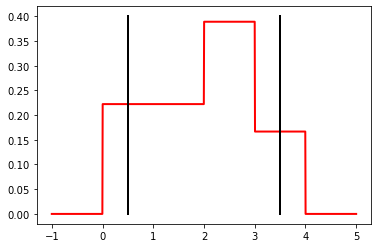

In [239]:
def p(x):
    prob=0
    if(x>=0 and x<=3):
        prob+=(1/3)*(2/3)
    if(x>=2 and x<=4):
        prob+=(1/2)*(1/3)
    return prob
probabilities = np.array([p(x) for x in np.linspace(-1,5,1000)])
plt.plot(np.linspace(-1,5,1000),probabilities,linewidth=2,color="red")
plt.plot([0.5,0.5],[0,0.4],linewidth=2,color="black")
plt.plot([3.5,3.5],[0,0.4],linewidth=2,color="black")
plt.show()

We can easily find the true area by calculating it (everything is just a box): $\frac{2}{9}\times1.5+(\frac{2}{9}+\frac{1}{6})\times1+\frac{1}{6}\times0.5=\frac{29}{36}$

In [242]:
print((2/9)*1.5+((2/9)+(1/6))*1+(1/6)*0.5)
print(29/36)

0.8055555555555555
0.8055555555555556


First, approximating with unnormalized importance sampling. Here using a uniform distribution between $-1$ and $5$ as $q(x):$

In [257]:
samples = np.random.uniform(-1,5,10000)
p_x = np.array([p(x) for x in samples])
f_x = (samples>=0.5)*(samples<=3.5)*1
q_x = np.ones_like(p_x)*(1/6)
approximation = (1/len(samples))*np.sum(f_x*(p_x/q_x))
print(approximation)

0.8105


Now, approximating with normalized importance sampling. Here, sampling from a normal distribution and using an unnormalized $p'(x)$.

In [258]:
def p_dash(x,alpha):
    prob=0
    if(x>=0 and x<=3):
        prob+=(1/3)*(2/3)
    if(x>=2 and x<=4):
        prob+=(1/2)*(1/3)
    return prob*alpha

In [280]:
samples = np.random.uniform(-1,5,10000)
p_dash_x = np.array([p_dash(x,1) for x in samples])
f_x = (samples>=0.5)*(samples<=3.5)*1
q_x = np.ones_like(p_dash_x)*(1/6)
weights = p_dash_x/q_x
approximation = (1/np.sum(weights))*np.sum(f_x*weights)
print(approximation)

0.8038751417328086


### Extension to any integral
We can reshape the formula to get an approximation to the integral of any function. If $f(x)=\frac{g(x)}{p(x)}$ then the formula becomes:
$$\int \frac{f(x)}{p(x)}p(x) dx \approx \frac{1}{N}\sum_{n=1}^N \frac{g(x_n)}{p(x_n)}$$
which simplifies to:
$$\int g(x) dx \approx \frac{1}{N}\sum_{n=1}^N \frac{g(x_n)}{p(x_n)}$$
Which gives the integral of a function without worrying about the distribution. Though obviously a distribution which doesn't reach all parts of the integral will give poor results.

**Example:**
Choosing a function $g$:
$$
g(x)=
\Bigg\{
\begin{aligned}
  & \frac{\cos{x}}{x^{2}+1}  \hspace{0.5cm} \text{for} \hspace{0.25cm}  x \epsilon [-5,5] \\
  & 0 \hspace{2.75cm} \text{otherwise}
\end{aligned}
$$
Showing the function:

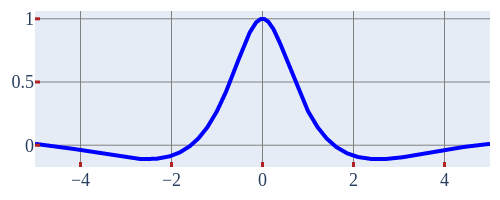

In [281]:
def g(x): return (1/(x**2+1))*np.cos(x)*(np.abs(x)<=5)
x_for_display = np.linspace(-5,5,1000)
g_values_for_display = g(x_for_display)
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_for_display, 
                         y=g_values_for_display,
                         mode="lines",
                         showlegend=False,
                         line=dict(width=4,color="blue")))
common_plots.set_basic_layout(fig)
fig.show(renderer="png",width=500,height=200)

The integral cannot be found by solving, so we could approximate it with sampling. For instance, using the uniform distribution between -5 and 5:

In [282]:
x_U = np.random.uniform(-5,5,1000000)
y_U = g(x_U)
prob_x_U = 1/10
print("monte carlo approximation, uniform sampling:",np.mean(y_U)/prob_x_U)

monte carlo approximation, uniform sampling: 1.0919730071043483


This lines up well with the approximation given by an online integral calculator, at 1.086264940339325 <br>
It is useful to note that in the above case the probability was the same for all values, so could be pulled out of the equation:$$\sum \frac{g(x)}{p(x)} = \sum \frac{g(x)}{\frac{1}{b-a}}$$.
$$ = (b-a) \sum g(x) $$.

But, it is also obviously possible to use something like a gaussian instead:

In [283]:
mean = 0
sigma = 1
x_G = np.random.normal(mean,sigma,1000000)
y_G = g(x_G)
prob_x_G = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x_G-mean)**2)/(sigma**2))
print("monte carlo approximation, gaussian sampling",np.mean(y_G/prob_x_G))

monte carlo approximation, gaussian sampling 1.094421262267126


The results are suprisingly good, even without truncating the gaussian. In this case you would want to cut the limits to be between -5 and 5.

It is worth mentioning at least 1 alternative. You could instead make a grid of values and assess the integral at each point in the grid. The area under the curve is approximated with the resulting histogram. As the number of steps grows the accuracy increases as well.

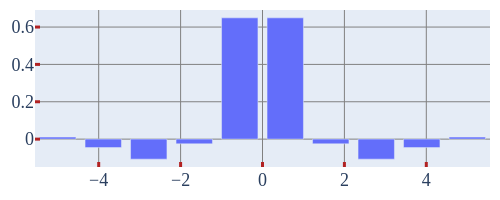

integral approximation: 0.9641681678745516


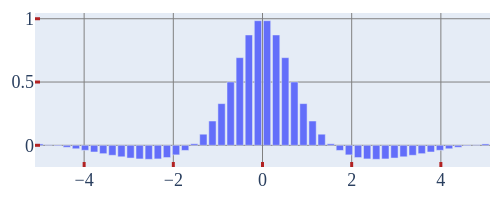

integral approximation: 1.0669440174672717


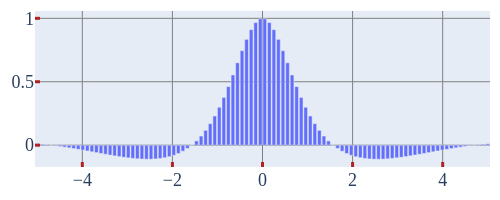

integral approximation: 1.076548325994053


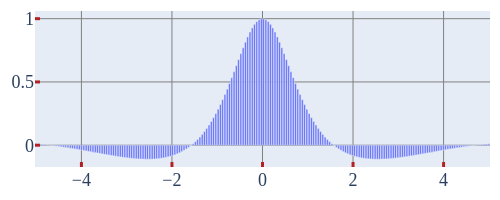

integral approximation: 1.0813928072754462


In [284]:
for grid_size in [10,50,100,200]:
    x_grid = np.linspace(-5,5,grid_size)
    g_grid_out = g(x_grid)
    fig = go.Figure([go.Bar(x=x_grid, y=g_grid_out)])
    common_plots.set_basic_layout(fig)
    fig.show(renderer="png",width=500,height=200)
    dx = 10/grid_size # gets the x spacing of each box. 
    integral_approximation = np.sum(dx*g_grid_out)
    print("integral approximation:",integral_approximation)

# Monte Carlo for Inference
One of the main uses of monte carlo techniques is in infering conditional distributions. You would like to get the probability mass in a given range, so need an integrator. E.g use samples from the conditional joint $p(B,D|A,C)$ to approximate things like $P(D|B,A,C)$. <br>
The key realization is that with a joint probability $p(X,Y,Z)$ you can integrate out variables, $$\int_X p(X,Y,Z) = P(Y,Z)$$ and write conditionals as one joint divided by another: $$p(X|Y,Z)=P(X,Y,Z)/P(Y,Z)$$ <br>
$P(X,Y,Z)$ and $P(Y,Z)$ can be approximated by counting the number of times they occur in the joint.
Using the same factors from earlier, say we want $P(D|A=0,B,C=0)$ (don't know $B$).

In [285]:
factor1 = factors.Factor(["D","B"],[2,2])
factor1.set_all([0.6,0.3,0.4,0.7])
factor2 = factors.Factor(["B","A","C"],[2,2,2])
factor2.set_all([0.2,0.6,0.1,0.5,0.8,0.4,0.9,0.5])
factor3 = factors.Factor(["A"],2)
factor3.set_all([0.25,0.75])
factor4 = factors.Factor(["C"],2)
factor4.set_all([0.65,0.35])
all_factors = [factor1,factor2,factor3,factor4]
known_vars = ["A","C"]
evidence = [0,0]

To do monte carlo driven inference we need to sample from the conditional joint distribution. Getting that:

In [286]:
new_factors = []
for f in all_factors:
    deleted_f = factors.drop_variables(f,known_vars,evidence)
    if(deleted_f!=None):
        new_factors.append(deleted_f)
combined_factor = factors.multiple_factor_product(new_factors)
combined_factor_norm = factors.condition(combined_factor)
print(combined_factor_norm)

D  B  Values (10 dp)
0  0  0.12
0  1  0.24
1  0  0.08
1  1  0.56



Then using monte carlo techniques:

In [287]:
samples = factors.sample(combined_factor_norm,1000)
prob_d0_b0 = np.sum((samples[:,0]==0)*(samples[:,1]==0))
prob_d0_b1 = np.sum((samples[:,0]==0)*(samples[:,1]==1))
prob_d1_b0 = np.sum((samples[:,0]==1)*(samples[:,1]==0))
prob_d1_b1 = np.sum((samples[:,0]==1)*(samples[:,1]==1))
prob_b0 = prob_d0_b0+prob_d1_b0
prob_b1 = prob_d0_b1+prob_d1_b1
prob_d0_given_b0 = prob_d0_b0/prob_b0
prob_d0_given_b1 = prob_d0_b1/prob_b1
prob_d1_given_b0 = prob_d1_b0/prob_b0
prob_d1_given_b1 = prob_d1_b1/prob_b1

print(prob_d0_given_b0.round(3))
print(prob_d0_given_b1.round(3))
print(prob_d1_given_b0.round(3))
print(prob_d1_given_b1.round(3))

0.592
0.3
0.408
0.7


Which matches closely with what you get with the analytical answer:

In [288]:
print(factors.condition(combined_factor_norm,"B"))

D  B  Values (10 dp)
0  0  0.6
0  1  0.3
1  0  0.4
1  1  0.7



# Sampling a Factor
The problem with the above method is it still requires calculating the full joint for conditionals. There are more efficient ways to sample from a factor which are discussed in the next notebook, which then makes monte carlo inference much more viable.

# Why does counting samples work?
The reason counting the number of times a variable is sampled works is because the probability of a variable can be expressed with indicator functions (1 if true, 0 if false):
$$P(X=x_n)=\int \mathbb{1}(x=x_n)p(x) dx$$
This just says the probability of a model is the integration of the probability distribution where the model is true. This is the same as saying:
$$P(X<x_n)=\int_{-\inf}^x p(x) $$
The top equation can be turned into a monte carlo equation:
$$\int \mathbb{1}(x=x_n)p(x) dx \approx \frac{1}{N} \sum_{i=1}^N \mathbb{1}(x_i=x_n) $$

In [289]:
# This is just to say, the probability of a variable is approximated by its occurances in samples:
some_samples = np.random.randint(0,3,10000)
prob_1 = np.sum(some_samples==1)/len(some_samples)
print(prob_1) # expect this to be around 1/3

0.3309
